# Suresonix Data Reduction
Dr Daniel Duke

Department of Mechanical & Aerospace Engineering

Monash University

18/10/2024

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import glob, datetime, os, natsort
import matplotlib as mpl
%matplotlib widget

In [255]:
tsvFiles = glob.glob("/Users/dduke/Desktop/Suresonix/raw_data_ASCII/*.txt")

In [256]:
filename=natsort.natsorted(tsvFiles)[0]

In [257]:
# Read data
with open(filename,'r') as F:
    for n in range(26): F.readline()
    header=F.readline().strip().split('\t')
    
M=np.genfromtxt(filename,skip_header=28,dtype="str")

In [258]:
# Process time stamp, convert from absolute to seconds since start of sampling
timestamps = []
for i in range(M.shape[0]):
    ts=datetime.datetime.strptime(' '.join(M[i,:3]),'%d/%m/%y %H:%M %S')
    if i==0: 
        ts0=ts
        timestamps.append(0.)
    else: timestamps.append((ts-ts0).total_seconds())
timestamps=np.array(timestamps)

timestamps -= 30 #s offset

In [259]:
# Size distribution data
size_bins = np.array([ float(x) for x in header[10:10+60] ])
size_dist = M[:,10:10+60].astype(float)

# Signal intensity
a = 1 - 0.01*M[:,7].astype(float)
Cv = M[:,8].astype(float)

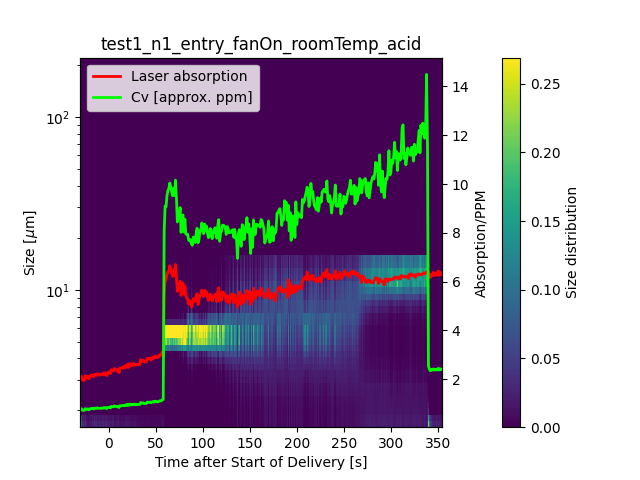

In [260]:
fig=plt.figure()

xx,yy=np.meshgrid(size_bins,timestamps)
p=plt.pcolormesh(yy,xx,np.nan_to_num(size_dist),shading='nearest',\
                 vmax=(0.5*np.nanmax(size_dist)),cmap='viridis')
plt.xlabel('Time after Start of Delivery [s]')
plt.ylabel(r'Size [$\mu$m]')
plt.title(os.path.basename(os.path.splitext(filename)[0]));
plt.gca().set_yscale('log')
plt.ylim(1.6,)

ax2=plt.gca().twinx()
plt.ylabel('Absorption/PPM')
ax2.plot(timestamps,a*100,lw=2,c='r',label='Laser absorption')
ax2.plot(timestamps,Cv,lw=2,c='lime',label='Cv [approx. ppm]')
cb=plt.colorbar(p,pad=0.12,label='Size distribution')
plt.legend();

In [261]:
# Conditional boxcar average
dt=30 #s
t=np.arange(0,timestamps.max(),dt)
size_dist_avg = [size_dist[0,:]]
a_avg = [0]; a_std=[0];
Cv_avg = [0]; Cv_std=[0];
for i in range(len(t)-1):
    # indices of points to average: within time window & absorption >1%
    i = np.where((timestamps<t[i+1])&(timestamps>=t[i])&(a>0.01))[0]
    size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
    a_avg.append( np.nanmean(a[i]) )
    Cv_avg.append( np.nanmean(Cv[i]) )
    a_std.append( np.nanstd(a[i]) )
    Cv_std.append( np.nanstd(Cv[i]) )
size_dist_avg = np.array(size_dist_avg)
a_avg = np.array(a_avg)
a_std = np.array(a_std)

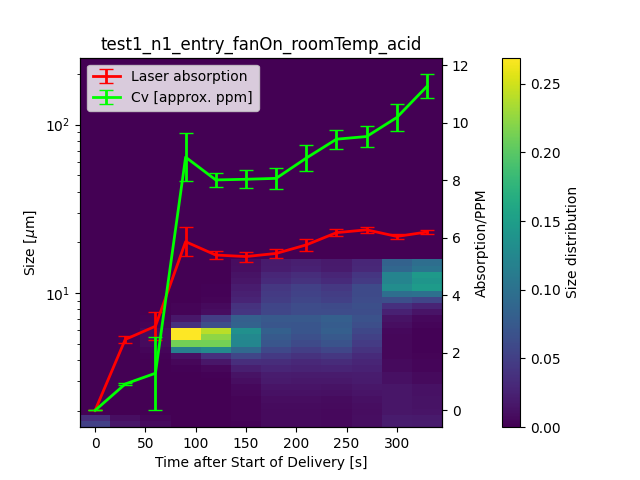

In [264]:
fig=plt.figure()

xx,yy=np.meshgrid(size_bins,t)
p=plt.pcolormesh(yy,xx,size_dist_avg,shading='nearest',vmax=(0.5*np.nanmax(size_dist)))
plt.gca().set_facecolor(mpl.colormaps['viridis'](0))
plt.xlabel('Time after Start of Delivery [s]')
plt.ylabel(r'Size [$\mu$m]')
plt.title(os.path.basename(os.path.splitext(filename)[0]));
plt.gca().set_yscale('log')
plt.ylim(1.6,250)

ax2=plt.gca().twinx()
plt.ylabel('Absorption/PPM')
ax2.errorbar(t,a_avg*100,yerr=a_std*100,lw=2,c='r',label='Laser absorption',capsize=5)
ax2.errorbar(t,Cv_avg,yerr=Cv_std,lw=2,c='lime',label='Cv [approx. ppm]',capsize=5)
cb=plt.colorbar(p,pad=0.12,label='Size distribution')
plt.legend();

## BATCH PROCESSING

In [312]:
# Process PCL TSV data, with time axis starting at 
# -time_offset and dt=30 for averaging window.
def process_timeseries(filename,time_offset=60,dt=30,plot_raw=False,a_min=0):
    
    # Read data
    with open(filename,'r') as F:
        for n in range(26): F.readline()
        header=F.readline().strip().split('\t')
    
    M=np.genfromtxt(filename,skip_header=28,dtype="str")

    # Process time stamp, convert from absolute to seconds since start of sampling
    timestamps = []
    for i in range(M.shape[0]):
        ts=datetime.datetime.strptime(' '.join(M[i,:3]),'%d/%m/%y %H:%M %S')
        if i==0: 
            ts0=ts
            timestamps.append(0.)
        else: timestamps.append((ts-ts0).total_seconds())
    timestamps=np.array(timestamps)
    
    timestamps -= time_offset #s offset

    # Size distribution data
    size_bins = np.array([ float(x) for x in header[10:10+60] ])
    size_dist = M[:,10:10+60].astype(float)
    
    # Signal intensity
    M[M[:,7]=='---',7:9]=np.nan # masking ---
    a = 1 - 0.01*M[:,7].astype(float)
    Cv = M[:,8].astype(float)

    if plot_raw:
        # Raw data plot
        fig=plt.figure()
    
        xx,yy=np.meshgrid(size_bins,timestamps)
        p=plt.pcolormesh(yy,xx,np.nan_to_num(size_dist),shading='nearest',\
                         vmax=(0.5*np.nanmax(size_dist)),cmap='viridis')
        plt.xlabel('Time after Start of Delivery [s]')
        plt.ylabel(r'Size [$\mu$m]')
        plt.title(os.path.basename(os.path.splitext(filename)[0]));
        plt.gca().set_yscale('log')
        plt.ylim(1.6,)
        
        ax2=plt.gca().twinx()
        plt.ylabel('Absorption/PPM')
        ax2.plot(timestamps,a*100,lw=2,c='r',label='Laser absorption')
        ax2.plot(timestamps,Cv,lw=2,c='lime',label='Cv [approx. ppm]')
        cb=plt.colorbar(p,pad=0.12,label='Size distribution')
        plt.legend();
        plt.savefig(os.path.splitext(filename)[0]+"_NoAveraging.png")
    
    # Conditional boxcar average
    t=np.arange(timestamps.min(),timestamps.max(),dt)
    size_dist_avg = [size_dist[0,:]]
    a_avg = [0]; a_std=[0];
    Cv_avg = [0]; Cv_std=[0];
    for i in range(len(t)-1):
        # indices of points to average: within time window & absorption sufficiently high
        i = np.where((timestamps<t[i+1])&(timestamps>=t[i])&(a>a_min))[0]
        size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
        a_avg.append( np.nanmean(a[i]) )
        Cv_avg.append( np.nanmean(Cv[i]) )
        a_std.append( np.nanstd(a[i]) )
        Cv_std.append( np.nanstd(Cv[i]) )
    size_dist_avg = np.array(size_dist_avg)
    a_avg = np.array(a_avg)
    a_std = np.array(a_std)

    fig=plt.figure()
    
    xx,yy=np.meshgrid(size_bins,t)
    p=plt.pcolormesh(yy,xx,size_dist_avg,shading='nearest',vmax=(0.5*np.nanmax(size_dist)))
    plt.gca().set_facecolor(mpl.colormaps['viridis'](0))
    plt.xlabel('Time after Start of Delivery [s]')
    plt.ylabel(r'Size [$\mu$m]')
    plt.title(os.path.basename(os.path.splitext(filename)[0]));
    plt.gca().set_yscale('log')
    plt.ylim(1.6,250)
    
    ax2=plt.gca().twinx()
    plt.ylabel('Absorption/PPM')
    ax2.errorbar(t,a_avg*100,yerr=a_std*100,lw=2,c='r',label='Laser absorption',capsize=5)
    ax2.errorbar(t,Cv_avg,yerr=Cv_std,lw=2,c='lime',label='Cv [approx. ppm]',capsize=5)
    cb=plt.colorbar(p,pad=0.12,label='Size distribution')
    plt.legend();
    plt.savefig(os.path.splitext(filename)[0]+"_30sAveraging.png")

    # Write table
    with open(os.path.splitext(filename)[0]+"_30sAveraging.csv",'w') as F:
        F.write('Time after Start of Delivery [s], Laser Absorption [-], Std Dev, Approx Cv [ppm], Std Dev, ')
        F.write('um , '.join(['%f' % s for s in size_bins])+'um\n')
        for i in range(len(t)):
            F.write('%f, %f, %f, %f, %f, ' % (t[i], a_avg[i], a_std[i], Cv_avg[i], Cv_std[i]))
            F.write(', '.join(['%f' % v for v in size_dist_avg[i,...]])+'\n')
    
    return

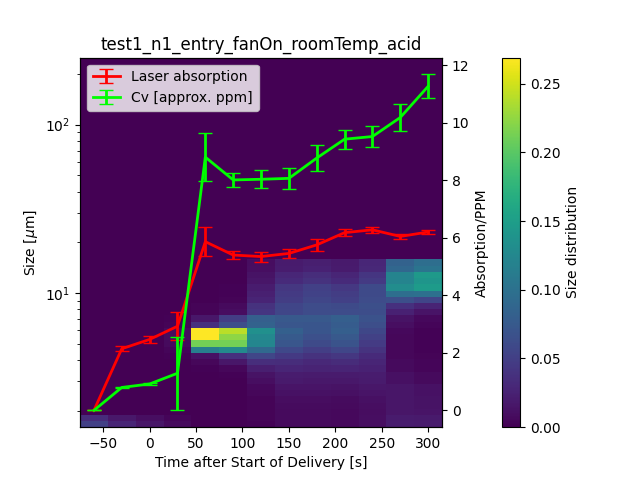

In [313]:
filenames=natsort.natsorted(tsvFiles)

process_timeseries(filenames[0])

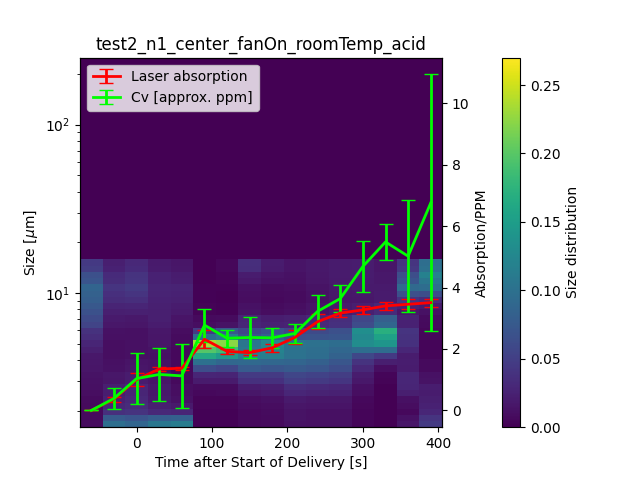

In [314]:
process_timeseries(filenames[1])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


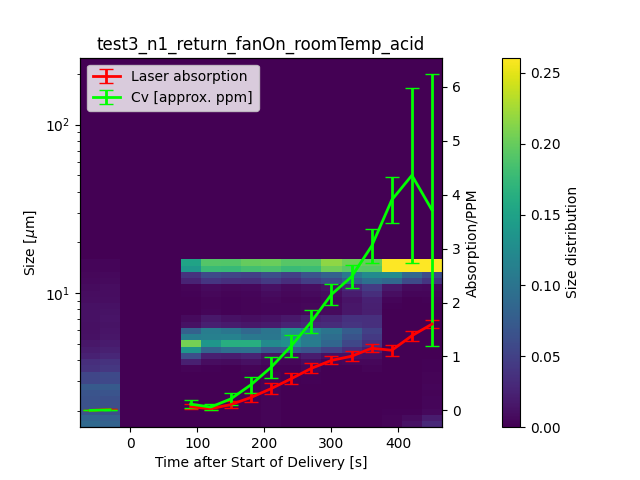

In [315]:
process_timeseries(filenames[2])

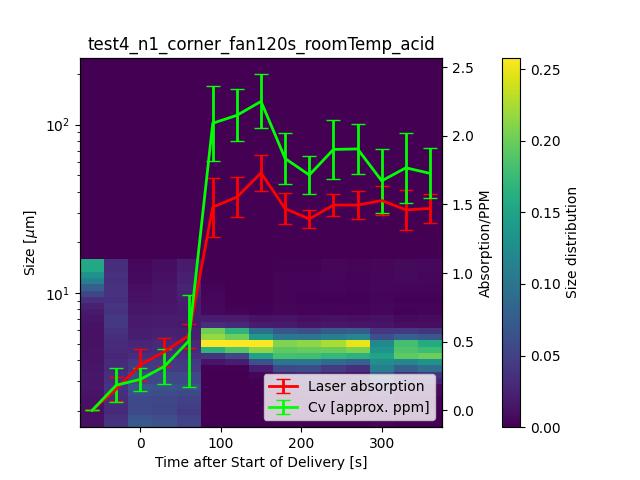

In [316]:
process_timeseries(filenames[3])

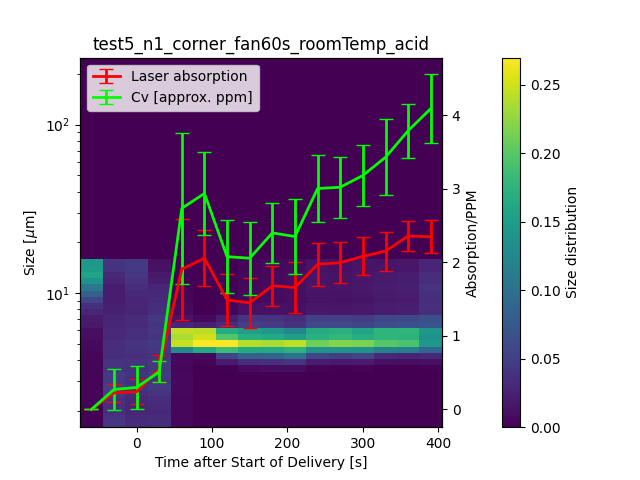

In [317]:
process_timeseries(filenames[4])

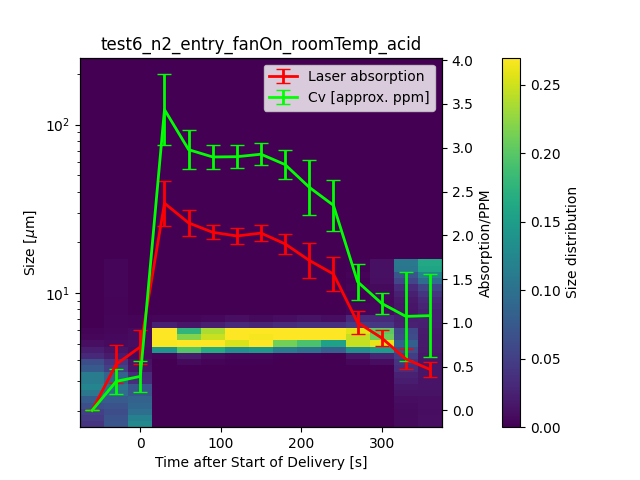

In [318]:
process_timeseries(filenames[5])

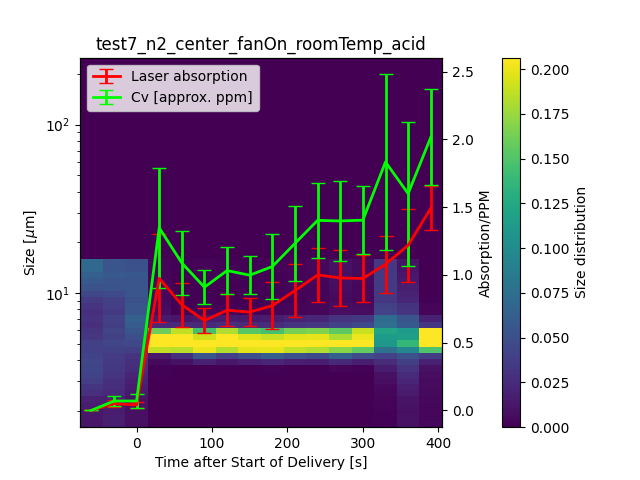

In [319]:
process_timeseries(filenames[6])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


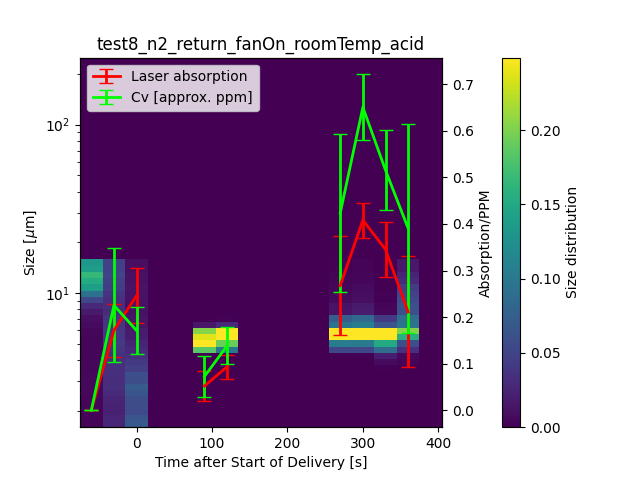

In [320]:
process_timeseries(filenames[7])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


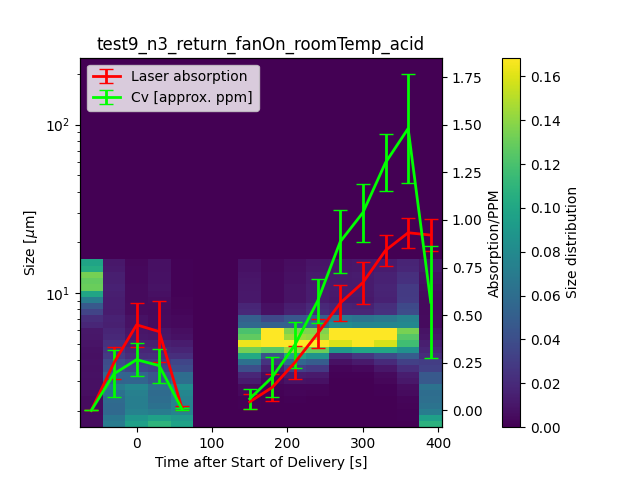

In [321]:
process_timeseries(filenames[8])

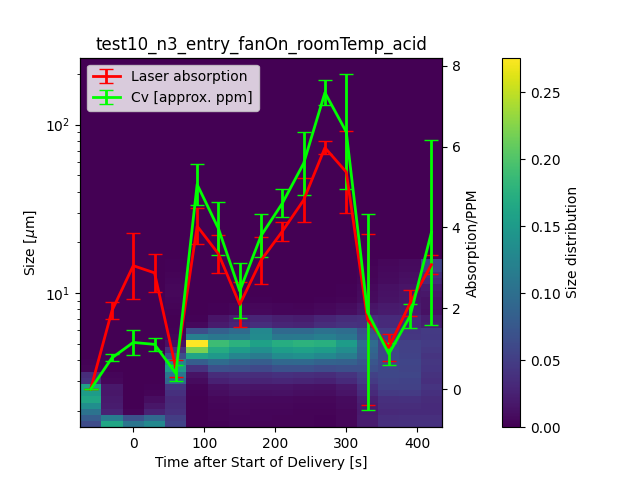

In [322]:
process_timeseries(filenames[9])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


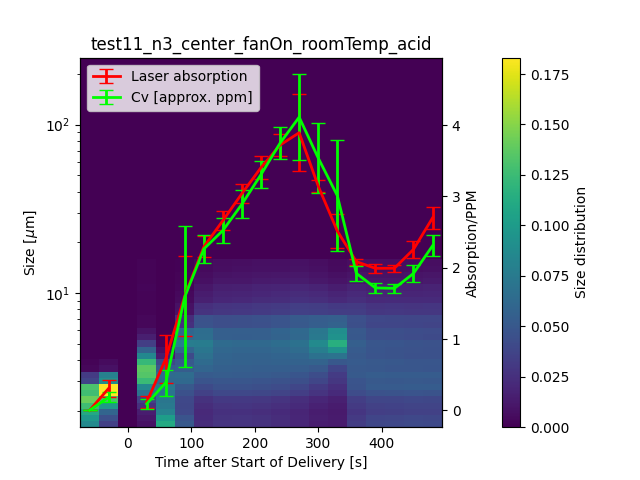

In [323]:
process_timeseries(filenames[10])

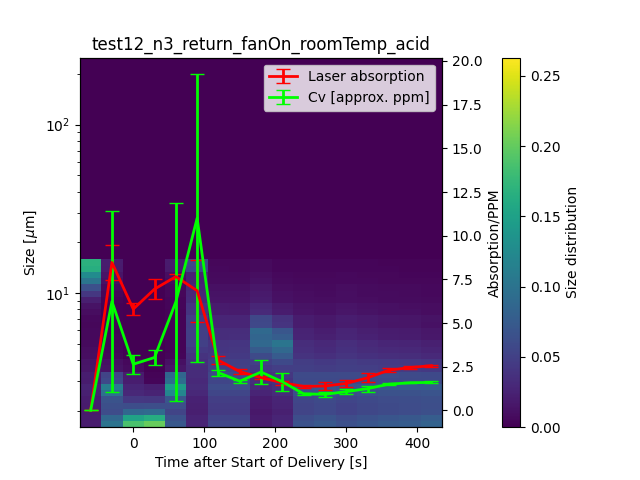

In [324]:
process_timeseries(filenames[11])

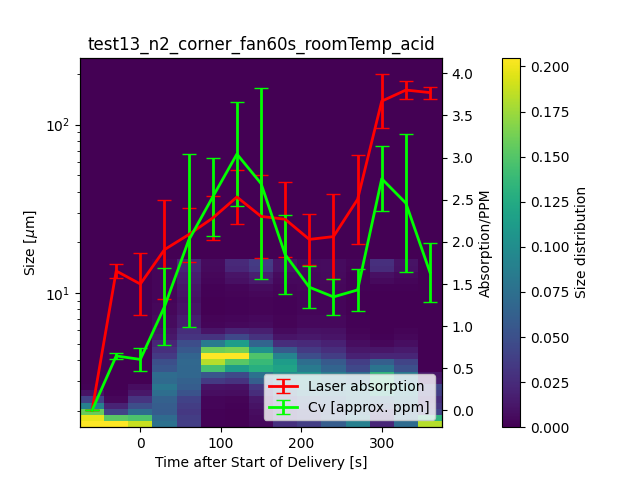

In [325]:
process_timeseries(filenames[12])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


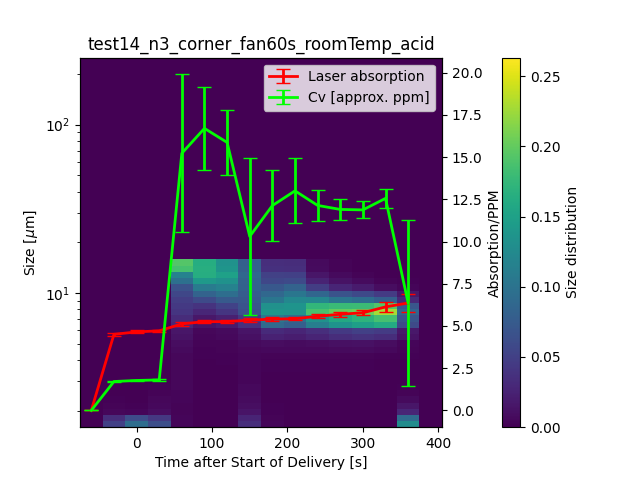

In [326]:
process_timeseries(filenames[13])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


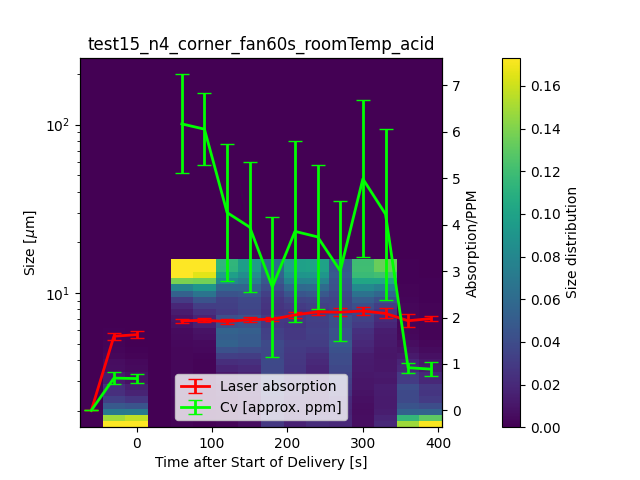

In [327]:
process_timeseries(filenames[14])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


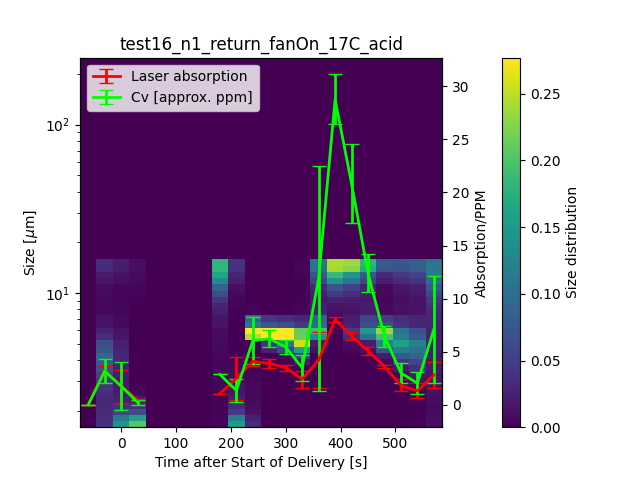

In [328]:
process_timeseries(filenames[15])

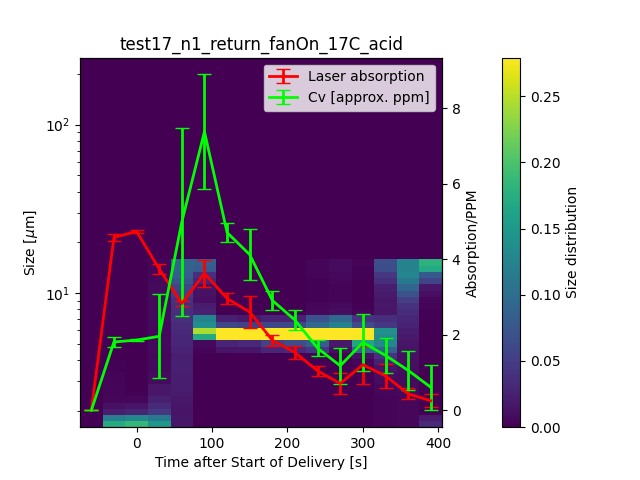

In [329]:
process_timeseries(filenames[16])

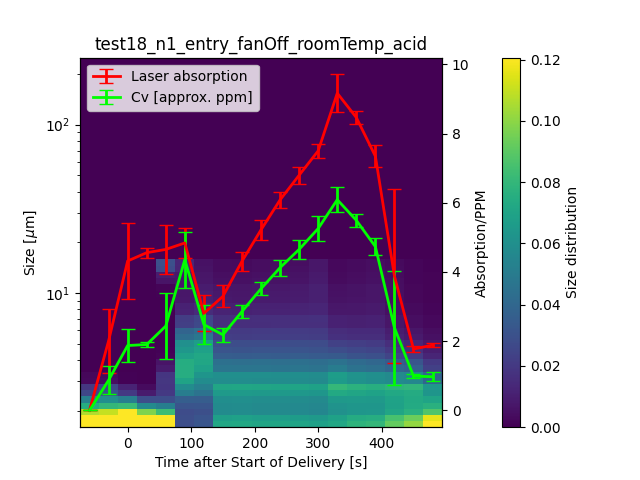

In [330]:
process_timeseries(filenames[17])

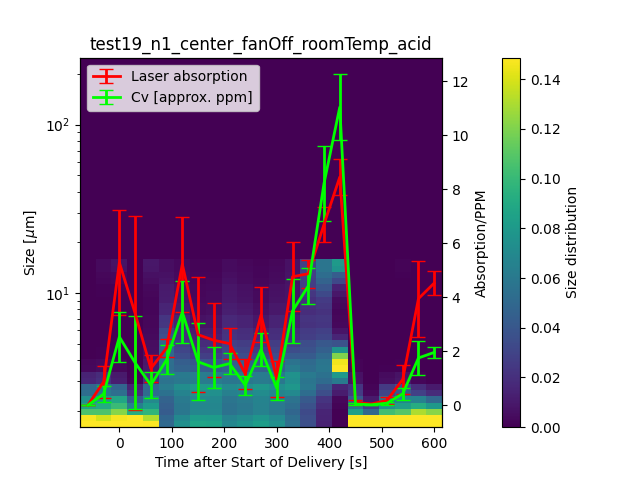

In [331]:
process_timeseries(filenames[18])

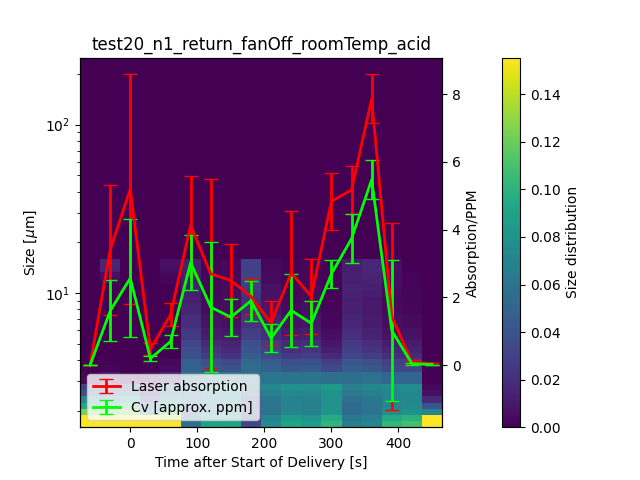

In [332]:
process_timeseries(filenames[19])

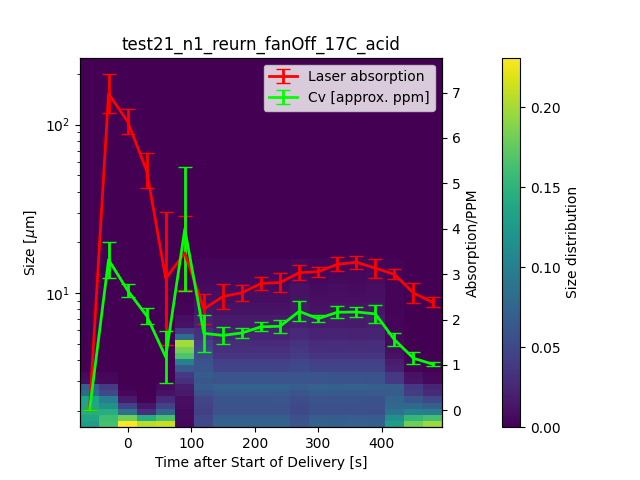

In [333]:
process_timeseries(filenames[20])

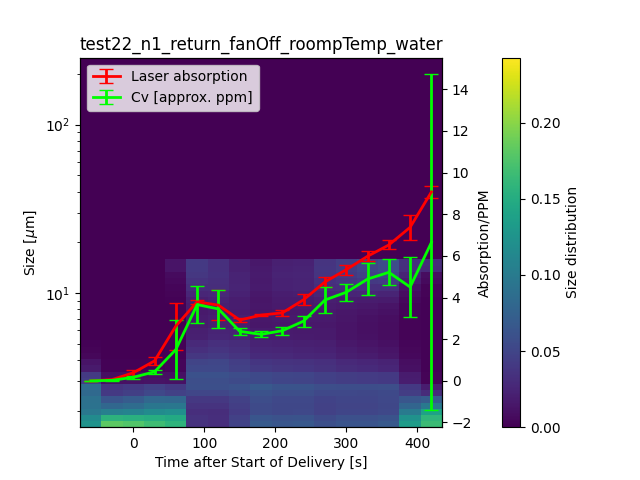

In [334]:
process_timeseries(filenames[21])

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:62: RuntimeWarning: Mean of empty slice
  size_dist_avg.append( np.nanmean(size_dist[i,:],axis=0) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:63: RuntimeWarning: Mean of empty slice
  a_avg.append( np.nanmean(a[i]) )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_30441/3421953992.py:64: RuntimeWarning: Mean of empty slice
  Cv_avg.append( np.nanmean(Cv[i]) )


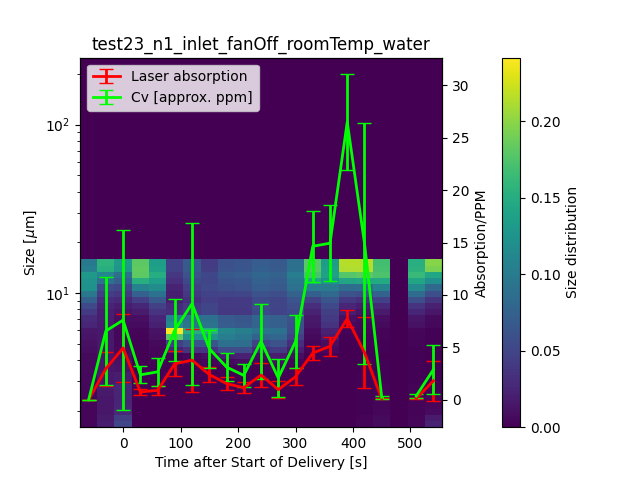

In [335]:
process_timeseries(filenames[22])